## EDA JFK Airport

We now do some preliminary data exploration on both the hourly and daily JFK time series. The main objective is to determine what seasonal and lag features we should use when fitting our models.

For context our objective is to fit two models one for both the daily and hourly time series. We will use both a linear regression with seasonal, lags and deterministic features (i.e. polynomial of some order). We will also fit a non linear model XGBoost as well as some more naive models like just using a lag of 1 or a lag of 7. 

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from jfk_taxis import create_rolling_average, create_rolling_average_hourly
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import pickle

In [2]:
# Get both the full daily and hourly time series
dir_path = "../data/processed/"
ts_daily = pd.read_csv(f"{dir_path}ts_daily2011-2025.csv")
ts_hourly = pd.read_csv(f"{dir_path}ts_hour2011-2025.csv")

# Convert dates to datetime objects
ts_daily["pickup_date"] = pd.to_datetime(ts_daily["pickup_date"])
ts_hourly["dt"] = pd.to_datetime(ts_hourly["dt"])


In [3]:
ts_daily.head()

pickup_date  trips
0  2011-01-01   2539
1  2011-01-02   3438
2  2011-01-03   8304
3  2011-01-04   7369
4  2011-01-05   6155

In [4]:
ts_hourly.head()

pickup_date  pickup_hour  trips                  dt
0  2011-01-01            0     82 2011-01-01 00:00:00
1  2011-01-01            1     72 2011-01-01 01:00:00
2  2011-01-01            2     15 2011-01-01 02:00:00
3  2011-01-01            3     12 2011-01-01 03:00:00
4  2011-01-01            4     11 2011-01-01 04:00:00

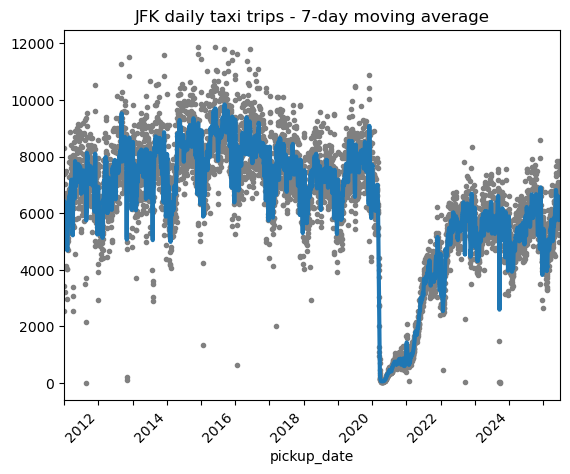

In [5]:
# It would be nice to start with a rolling average, we begin with one for the daily ts and we will do a 7 day rolling average

# Create a daily counts pandas series indexed by pickup_date with trips as the value
daily_counts = ts_daily["trips"]
daily_counts.index = ts_daily["pickup_date"]

# Create rolling average using helper function
create_rolling_average(7, daily_counts)

This seems a good start and the rolling average fits the data reasonably well. We would like to experiment with a much larger window size of say 30 or 60 days in the following.

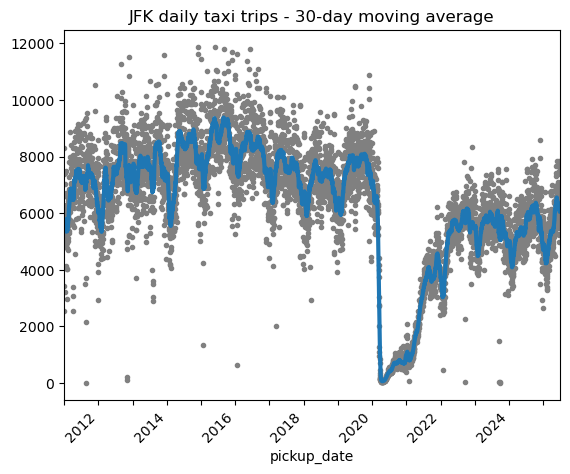

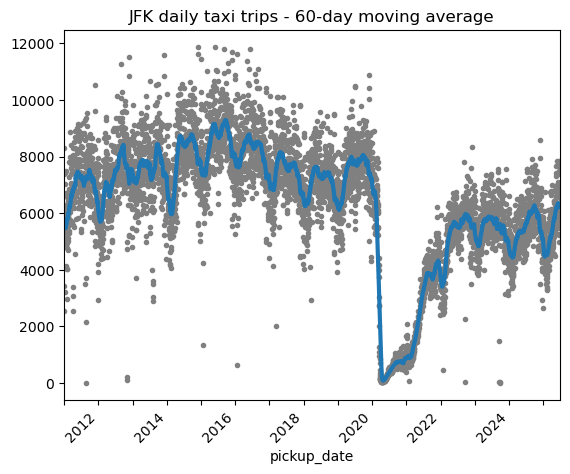

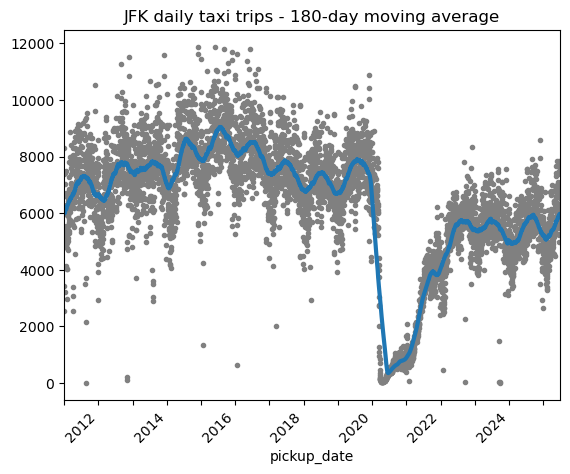

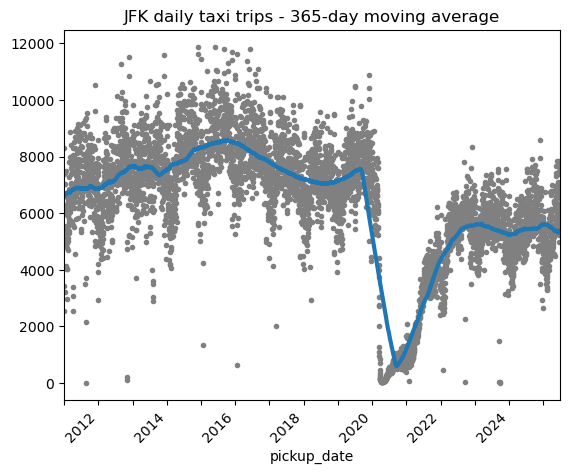

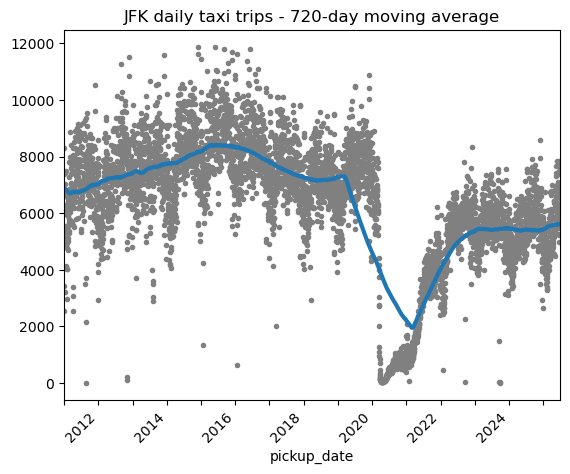

In [6]:
for size in [30, 60, 180, 365, 720]:
    create_rolling_average(size, daily_counts)

It is interesting to observe that larger windows like 365 do capture the general trend of the data very well, suggesting there is some yearly seasonality to the data as we may possibly expect (e.g. more taxis at an Airport during the holidays). At a larger window size like 720 things do begin to break down which again possibly suggests that yearly seasonality might be the largest period we can obtain. Smaller windows like 30, 60, 180 also do a good job catching the general trend in the data suggesting there will be perhaps a bi or quartely seasonality to the data. 

We now investigate rolling averages applied to the hourly counts.

In [17]:
# Create a hourly counts pandas series indexed by pickup_date with trips as the value
hourly_counts = ts_hourly["trips"]
hourly_counts.index = ts_hourly["dt"]



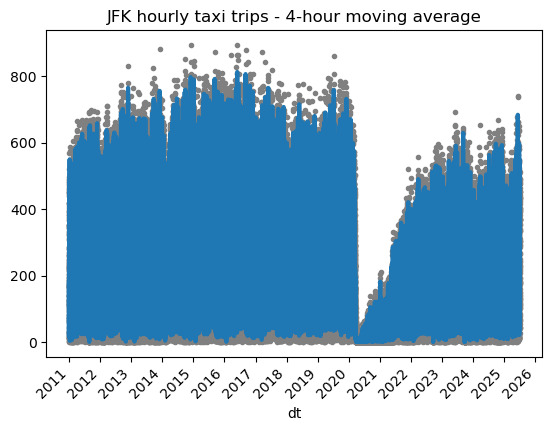

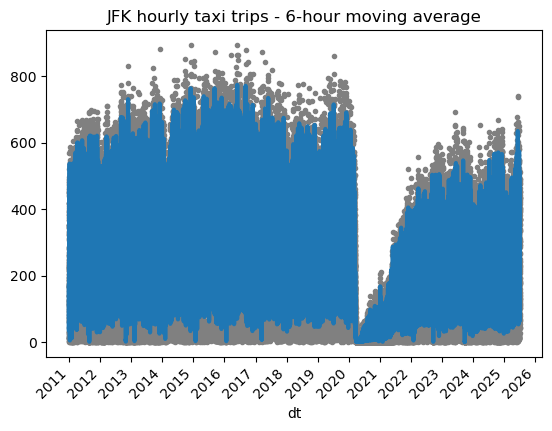

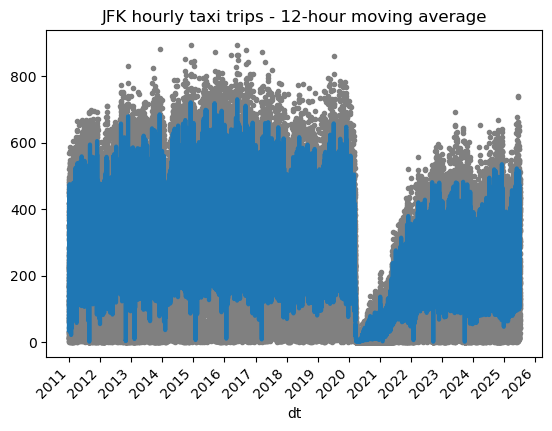

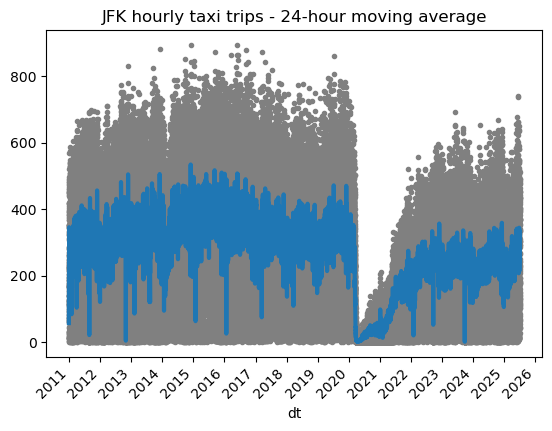

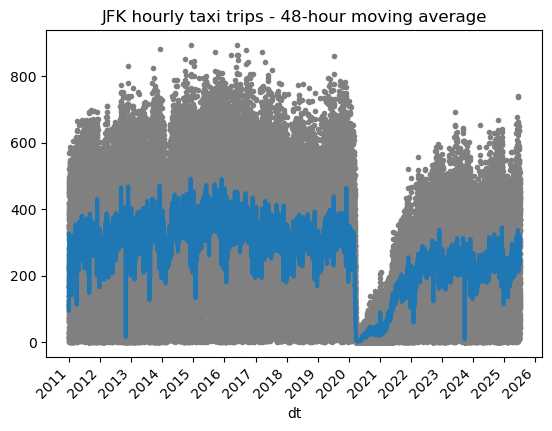

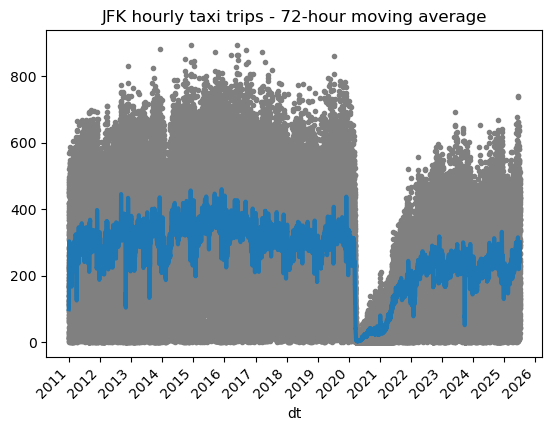

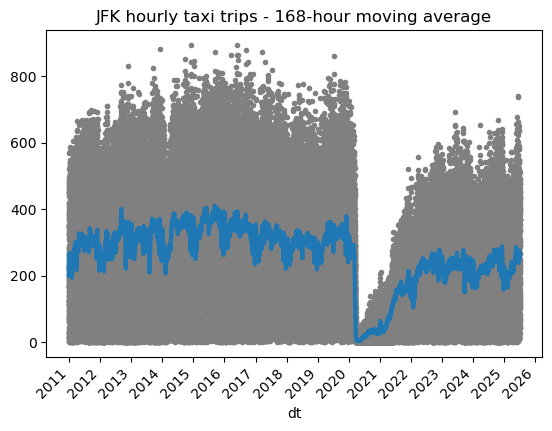

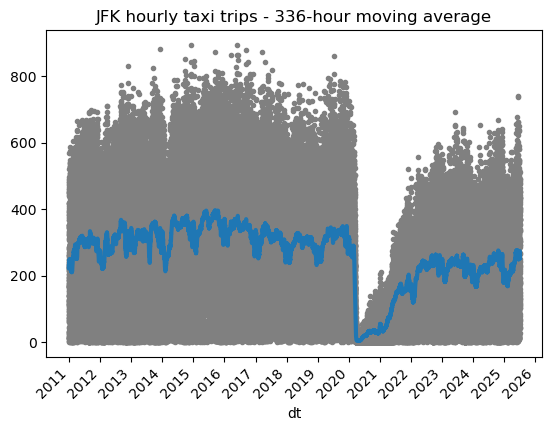

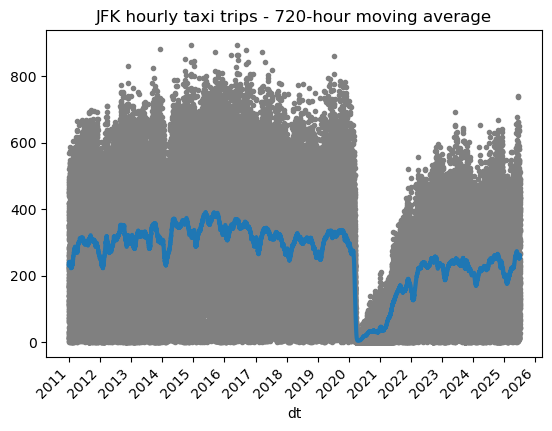

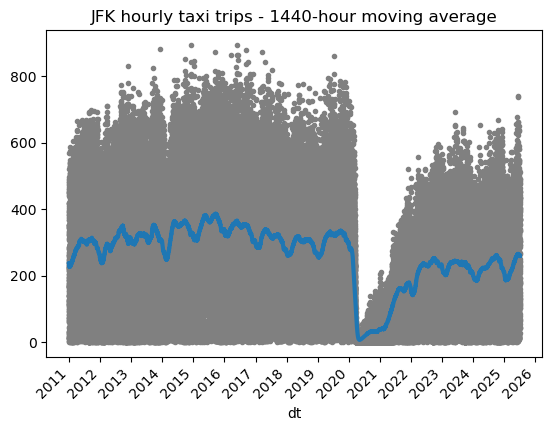

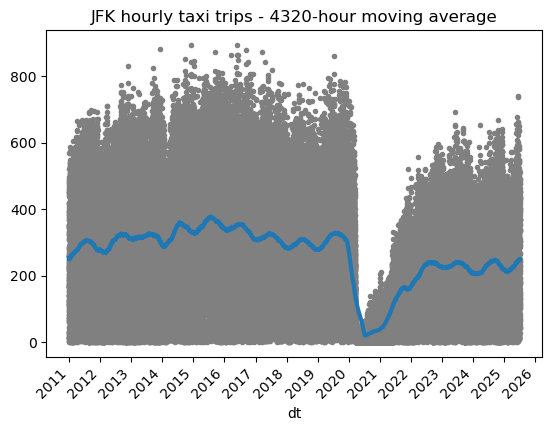

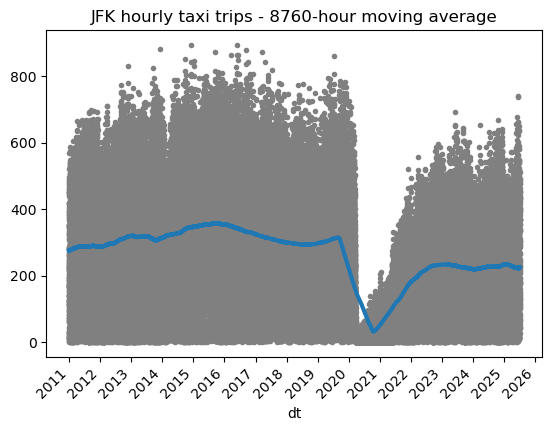

In [62]:
for size in [4, 6, 12, 24, 48, 72, 168, 336, 720, 1440, 4320, 8760]:
    # Create rolling average using helper function
    create_rolling_average_hourly(size, hourly_counts)

The rolling averages don't appear to be as useful here at larger values (8760 correpsonds to one year). However at smaller values like 12, 24, 48, 72 it does seem to be capturing some of the general trend within the data although it is a little hard to tell as there are so many points in the plot that it looks very messy.

We now seek to try and understand the seasonality in more detail, we will use statsmodels seasonal_decompose.

Period: 7


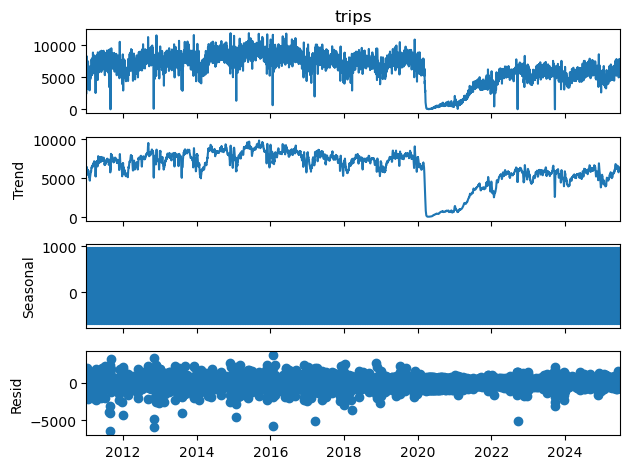

Period: 14


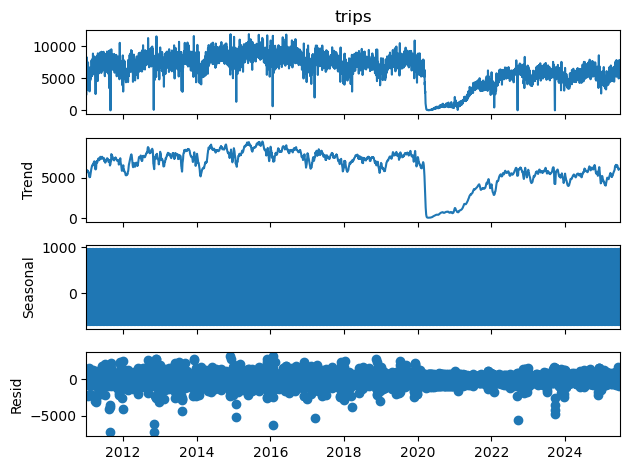

Period: 28


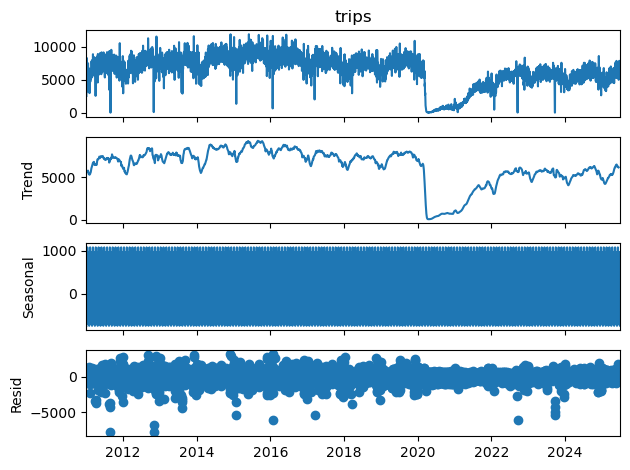

Period: 30


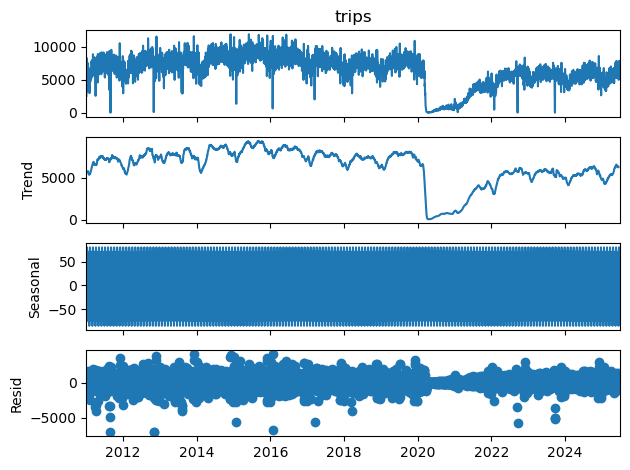

Period: 60


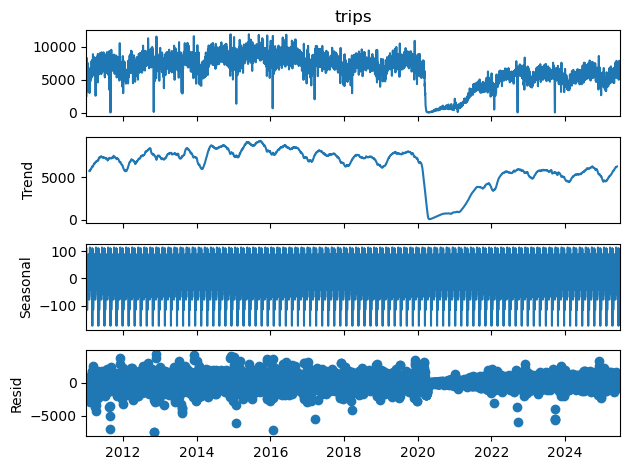

Period: 180


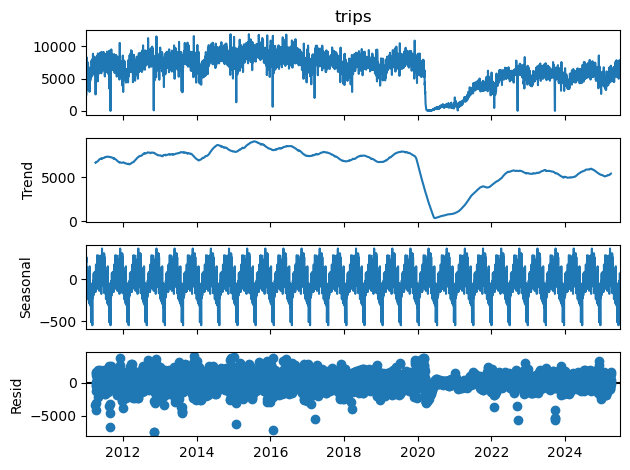

Period: 365


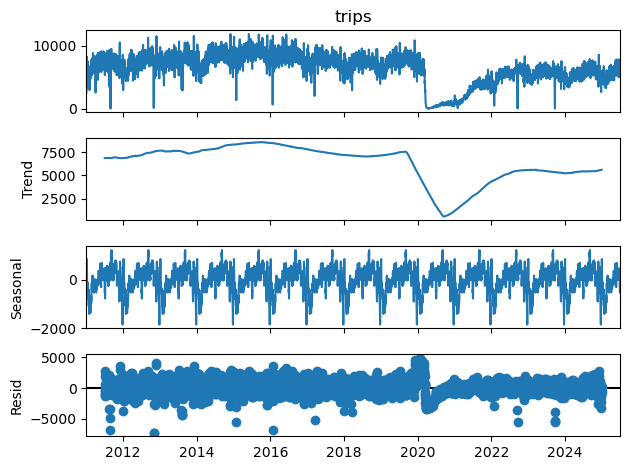

Period: 730


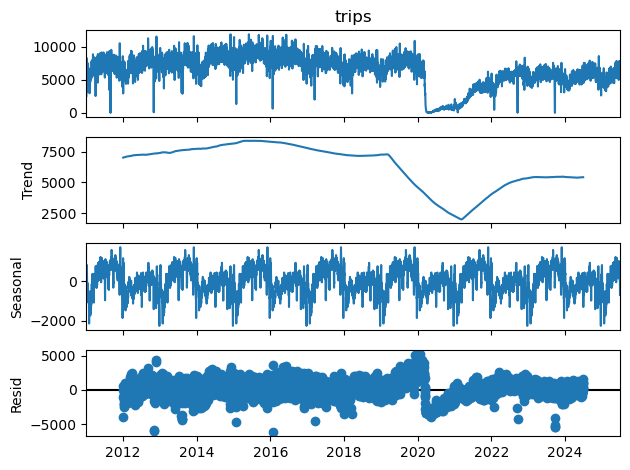

In [30]:
# Periods to try:
for period in [7, 14, 28, 30, 60, 180, 365, 730]:
    print(f"Period: {period}")
    result = seasonal_decompose(daily_counts, model = "additive", period = period)
    result.plot() 
    plt.show()


From this it seems that yearly seasonality is the best fit for the data which is what we would have expected! Period 730 also looks okay but it will be easier to interpret a yearly seasonality than a bi yearly one.

We now repeat this process for the hourly time series.

Period: 4


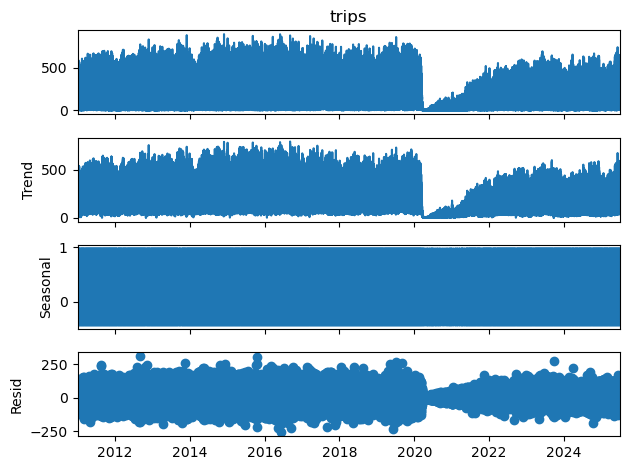

Period: 6


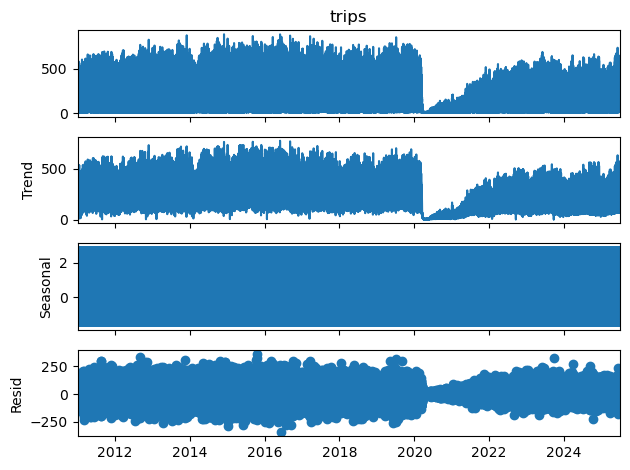

Period: 12


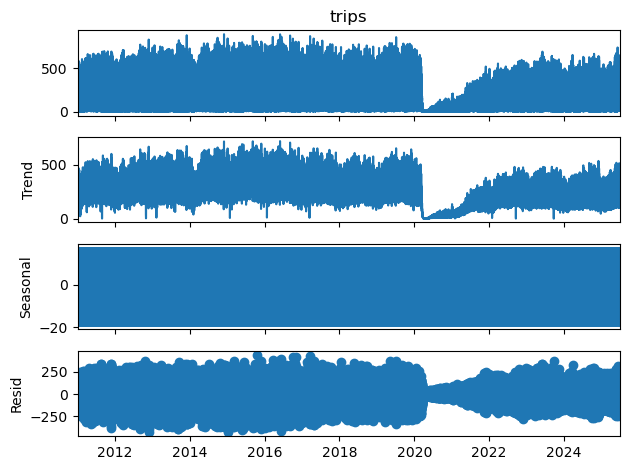

Period: 24


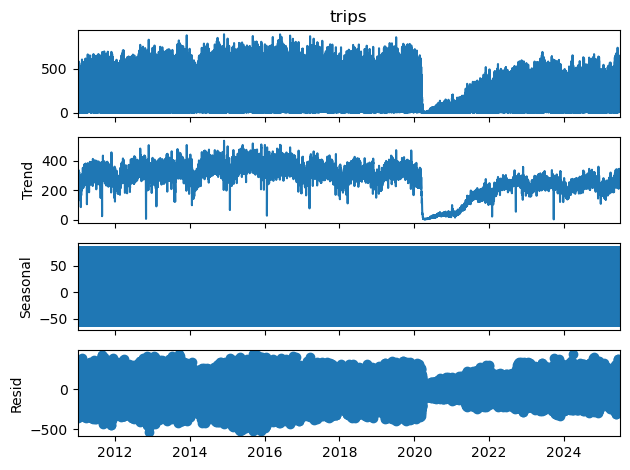

Period: 48


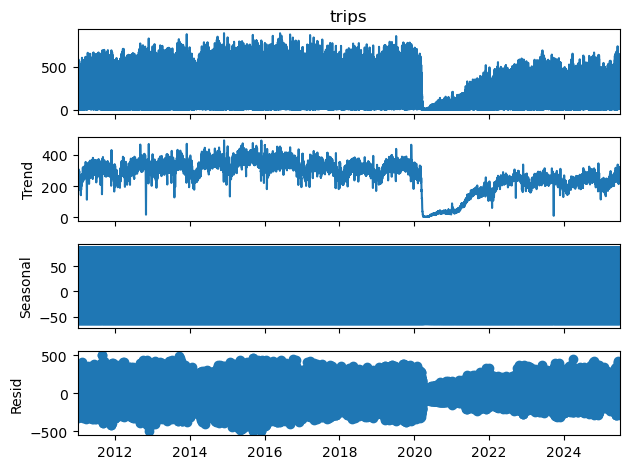

Period: 72


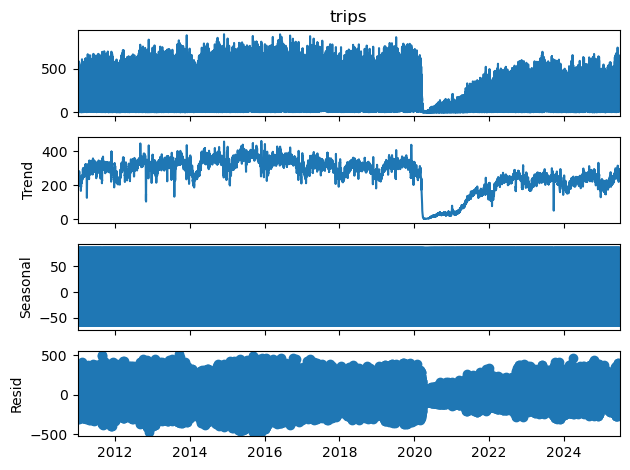

Period: 168


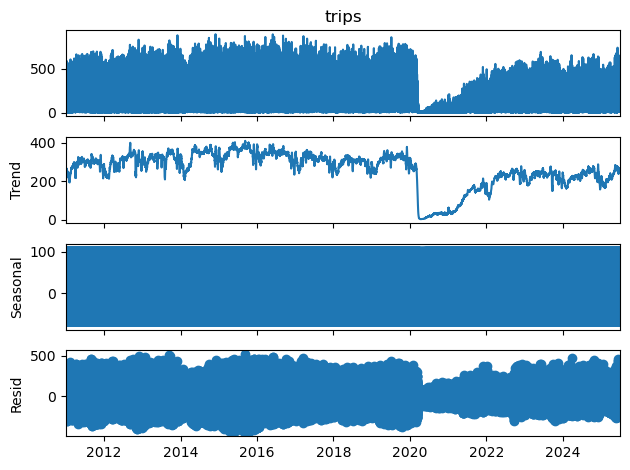

Period: 336


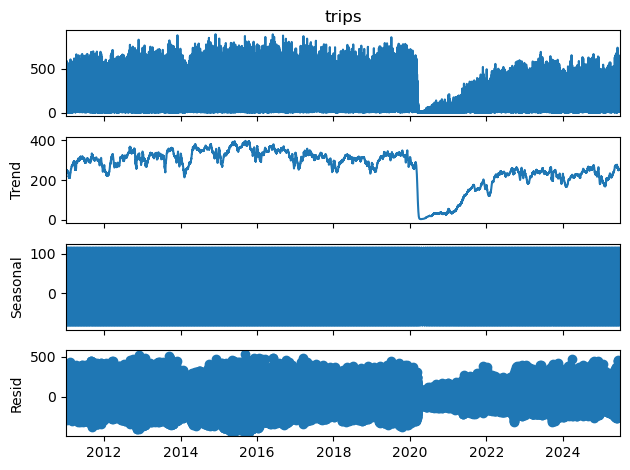

Period: 720


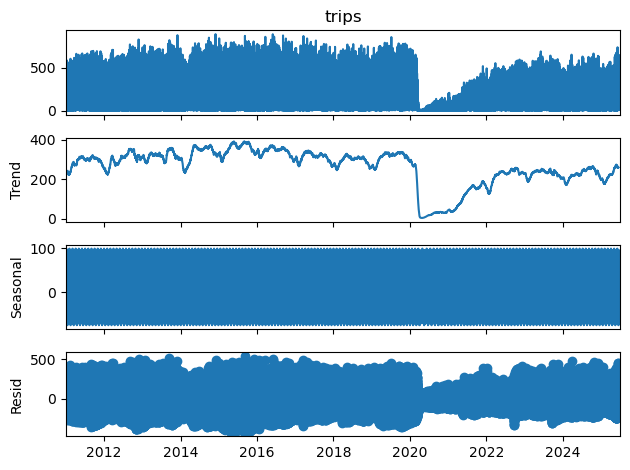

Period: 1440


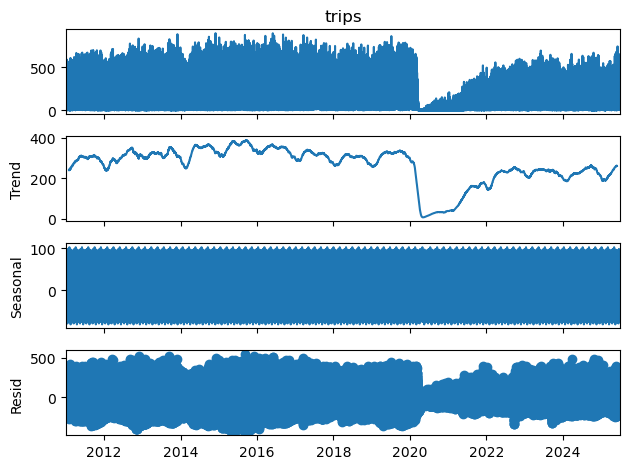

Period: 4320


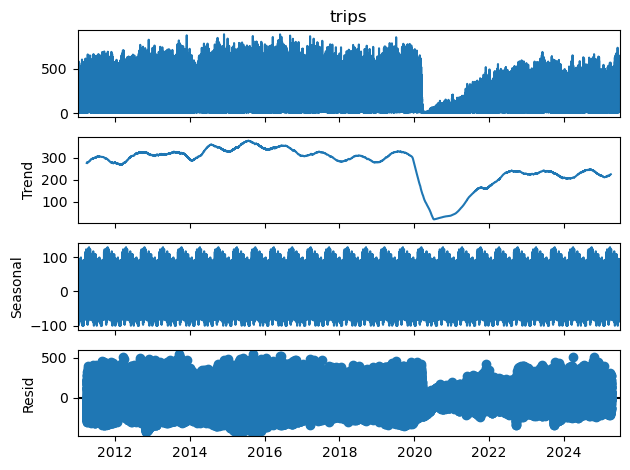

Period: 8760


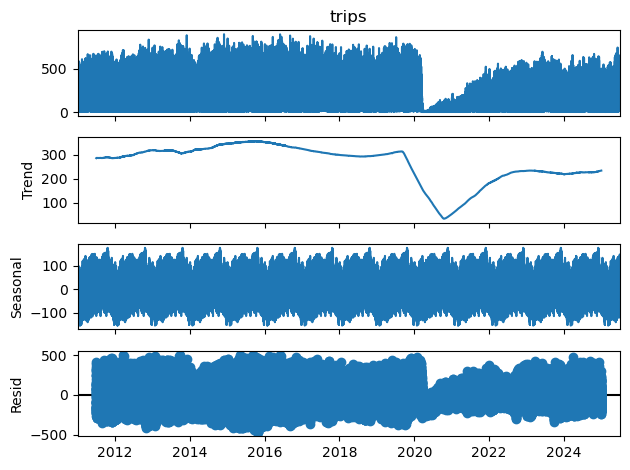

In [61]:
# Periods to try:
for period in [4, 6, 12, 24, 48, 72, 168, 336, 720, 1440, 4320, 8760]:
    print(f"Period: {period}")
    result = seasonal_decompose(hourly_counts, model = "additive", period = period)
    result.plot() 
    plt.show()

The above are incredibly hard to read due to the large number of data points, there are O(100,000) data points in our hourly_counts df. This would suggest that looking only at maybe a month or few months is far more helpful with hourly data and potentially even with daily data as well.

Period: 4


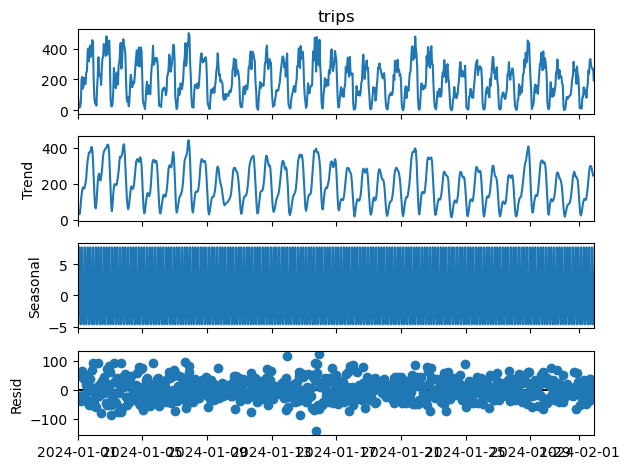

Period: 6


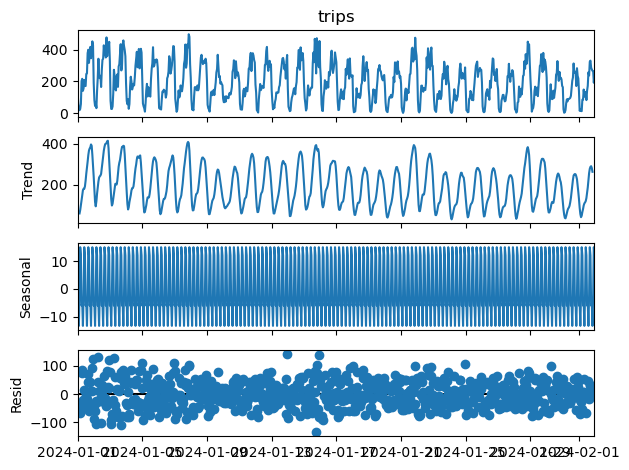

Period: 12


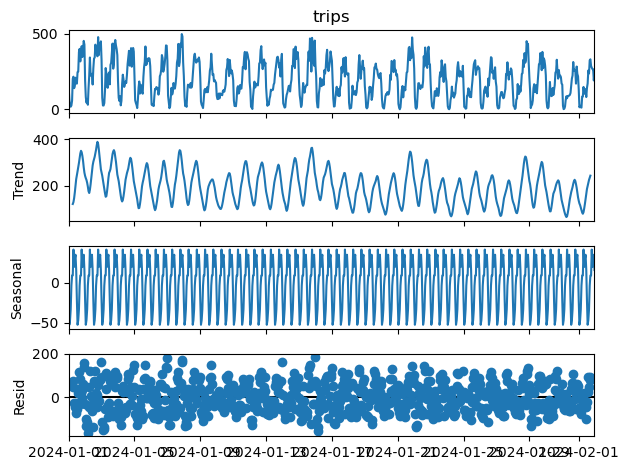

Period: 24


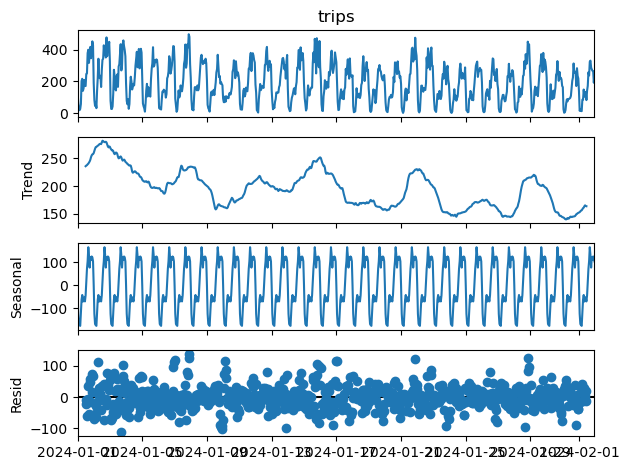

Period: 48


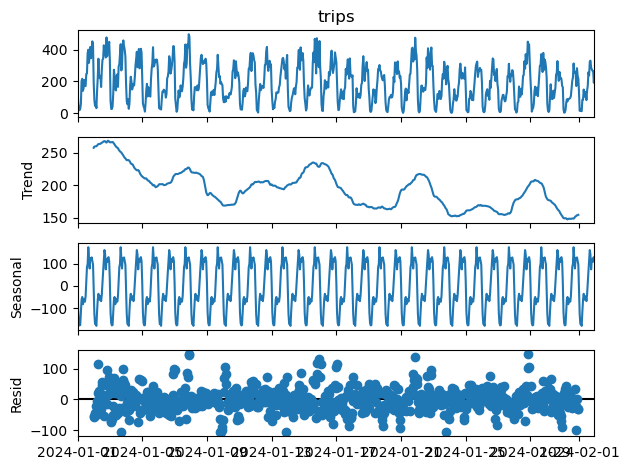

Period: 72


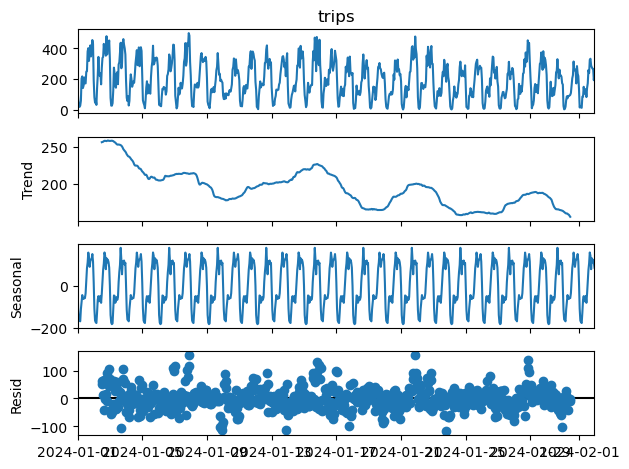

Period: 168


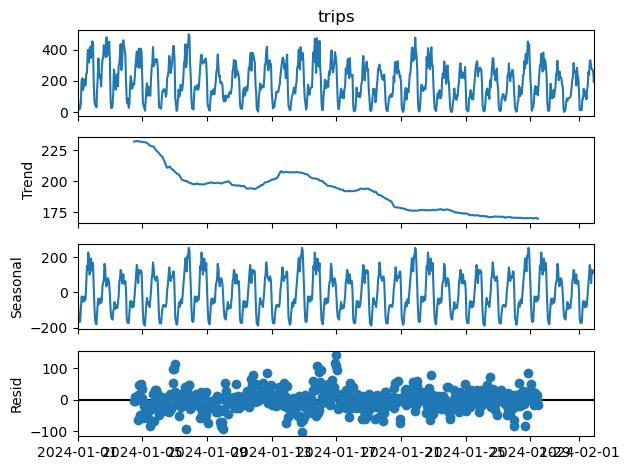

Period: 336


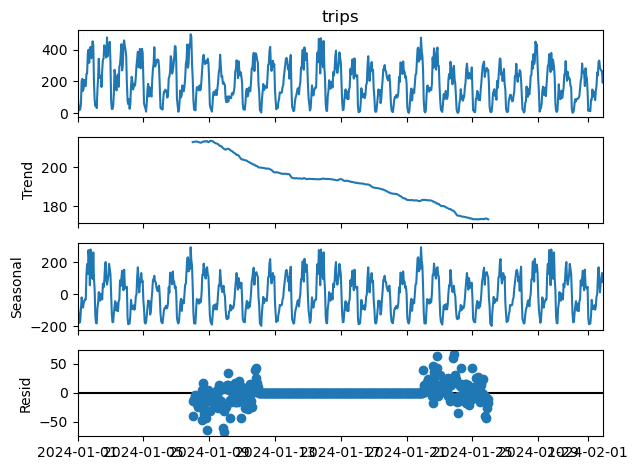

In [41]:
# It is likely worth only looking at a months worth of data so we can see the seasonal trends a bit clearer

hourly_counts_2024 = hourly_counts["2024-01-01":"2024-02-01"]

# Periods to try:
for period in [4, 6, 12, 24, 48, 72, 168, 336]:
    print(f"Period: {period}")
    result = seasonal_decompose(hourly_counts_2024, model = "additive", period = period)
    result.plot() 
    plt.show()
   

We see some very clear 24, 48 and 72 hour seasonality in the data, as 48, 72 are just multiples of 24 this would suggest 24 hour seasonality is the strongest for the hourly data. Which again lines up with what we would expect. It is likely not possible to see this is in the previous plots due to the sheer number of data points. It is worth checking that this holds across different months which we do in the below.

It is a little hard to tell whether 12 hours does give seasonality or not and is worth testing this on an even smaller subset of the data. We will also do this below.

Period: 12, series: 1


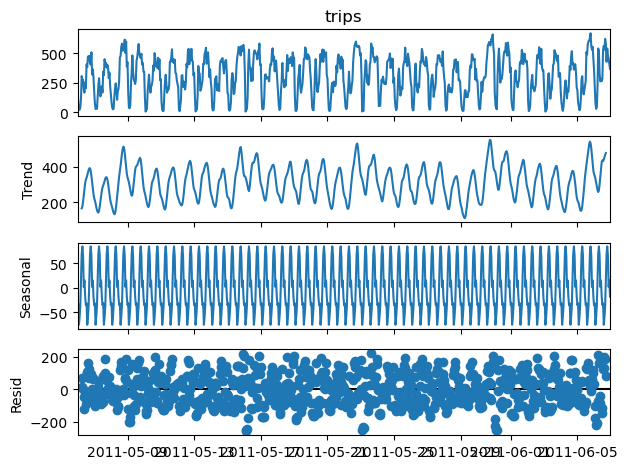

Period: 24, series: 1


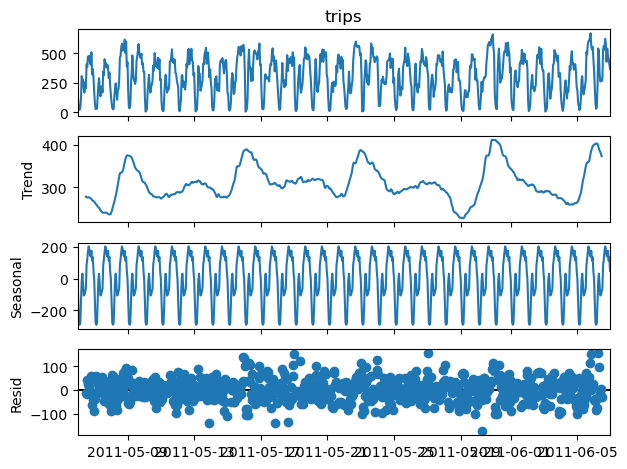

Period: 48, series: 1


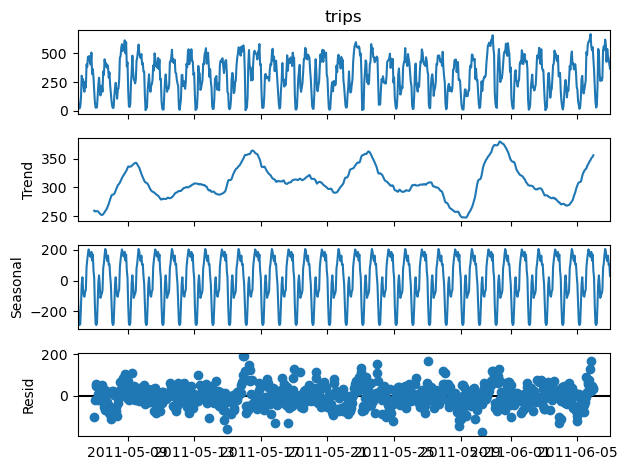

Period: 72, series: 1


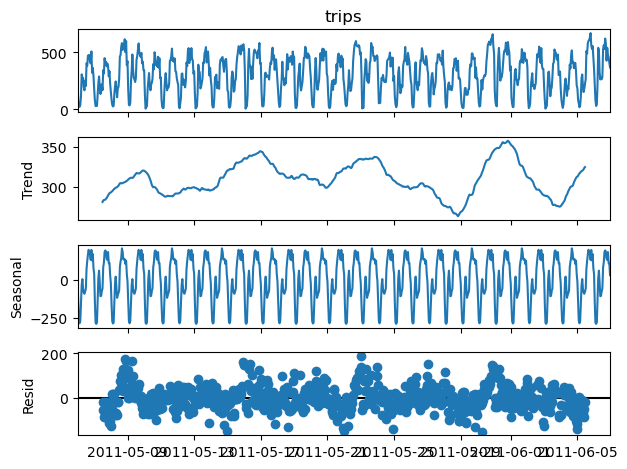

Period: 168, series: 1


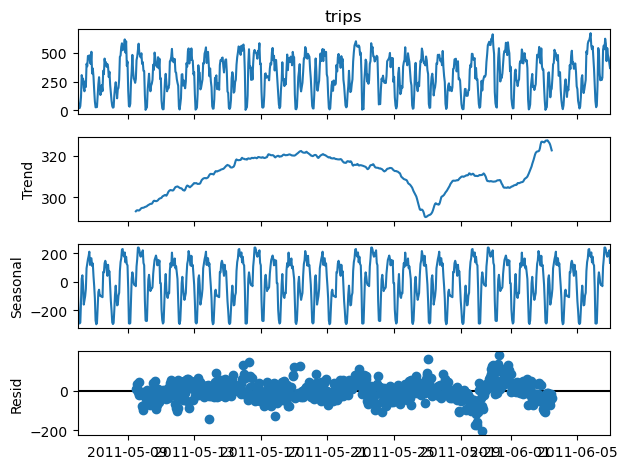

Period: 12, series: 2


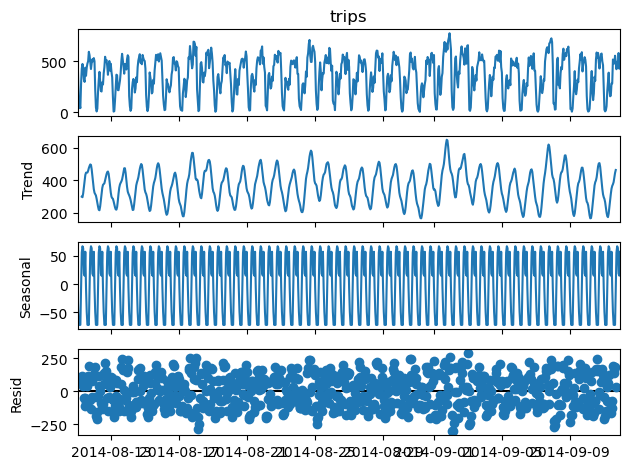

Period: 24, series: 2


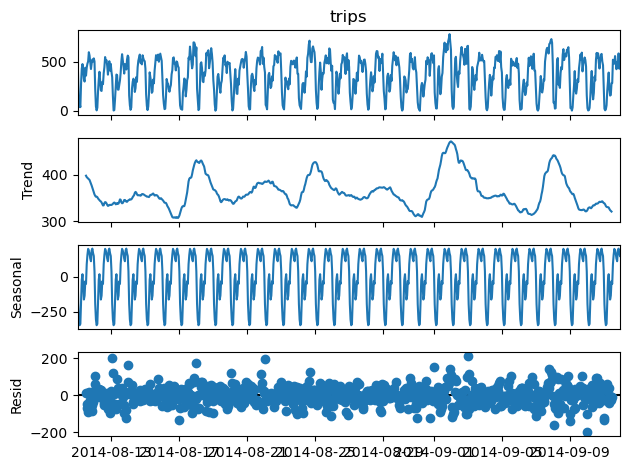

Period: 48, series: 2


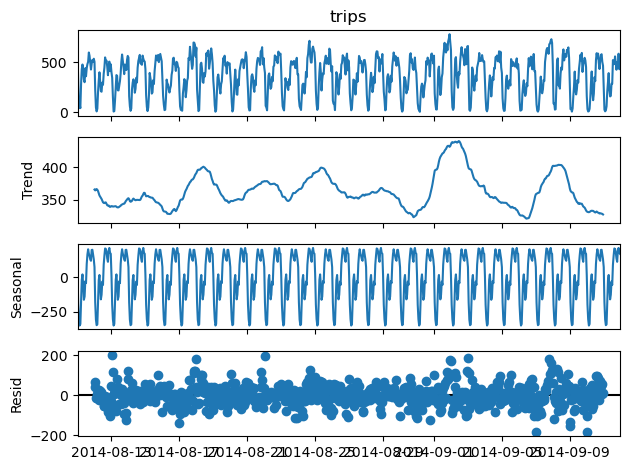

Period: 72, series: 2


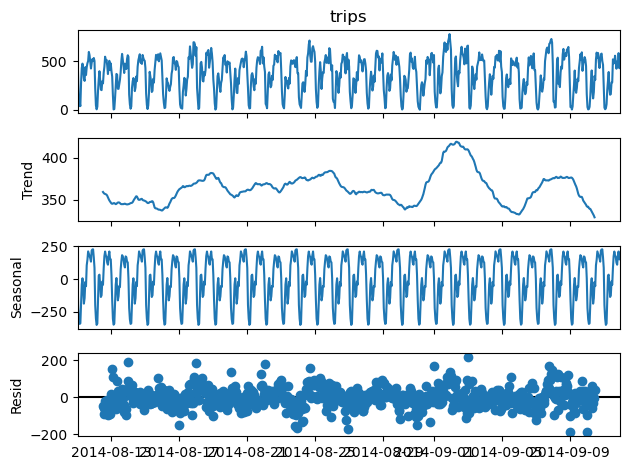

Period: 168, series: 2


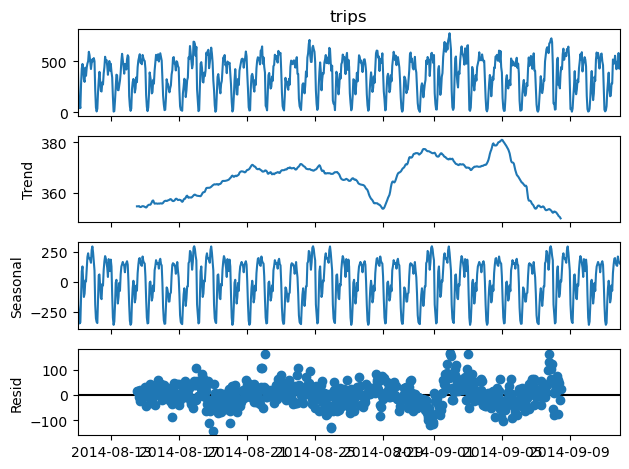

Period: 12, series: 3


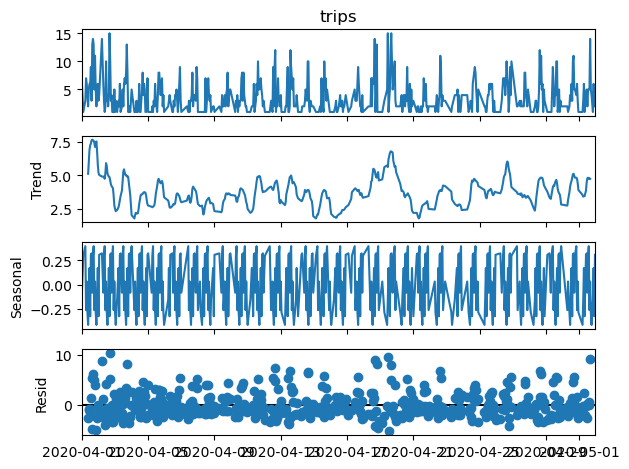

Period: 24, series: 3


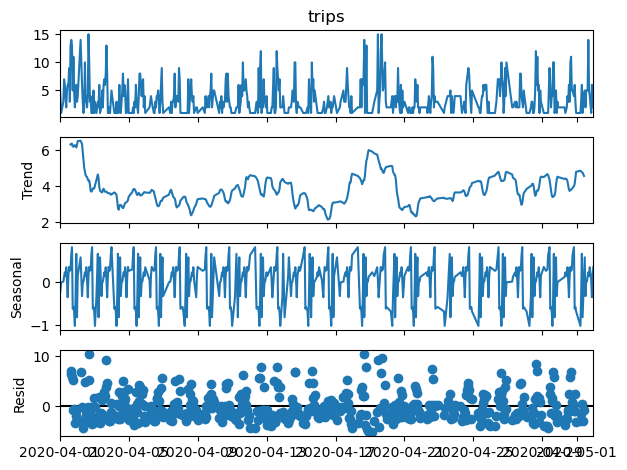

Period: 48, series: 3


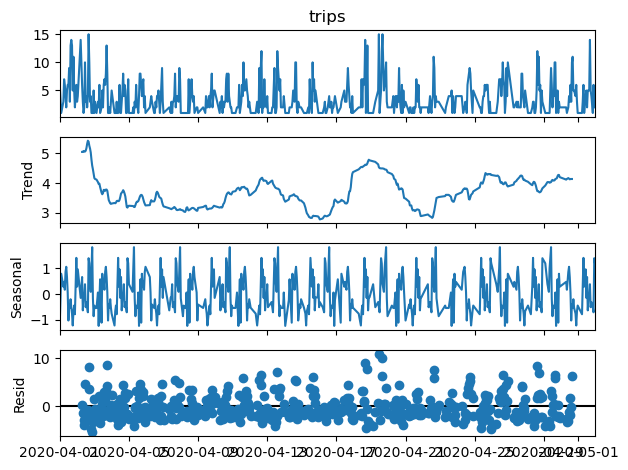

Period: 72, series: 3


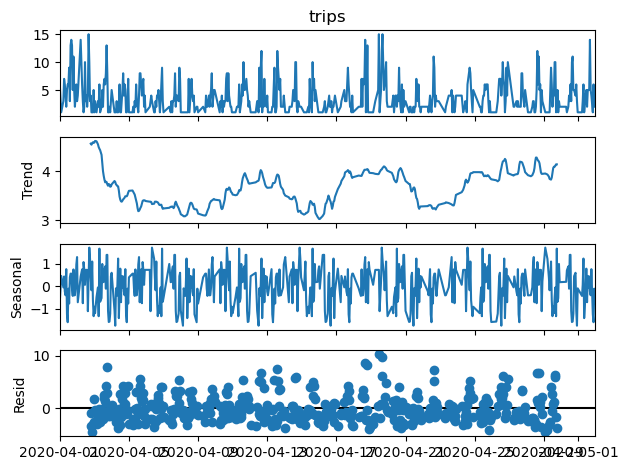

Period: 168, series: 3


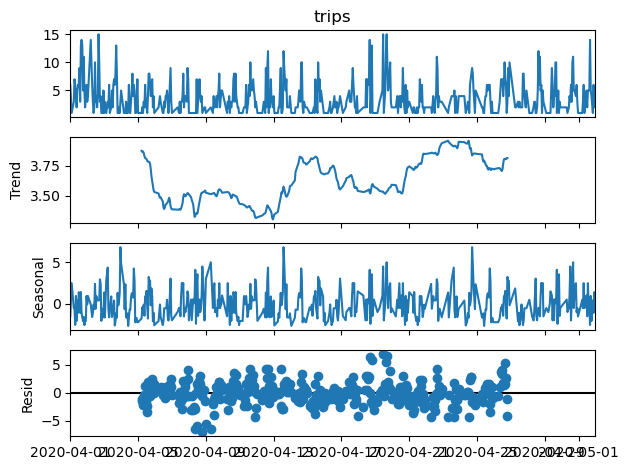

12 hour test


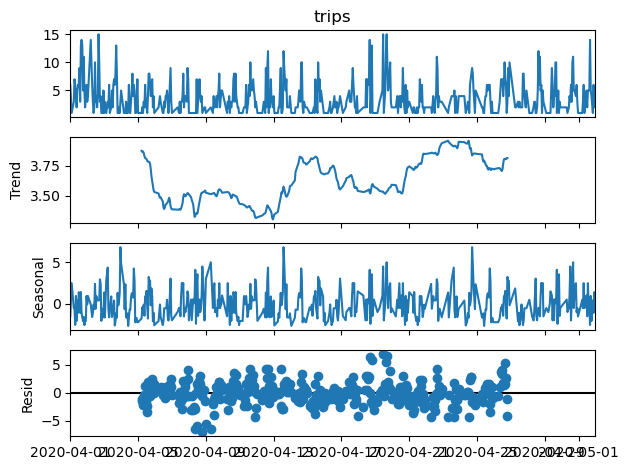

In [64]:
hourly_counts_1 = hourly_counts["2011-05-06":"2011-06-06"]
hourly_counts_2 = hourly_counts["2014-08-11":"2014-09-11"]
hourly_counts_3 = hourly_counts["2020-04-01":"2020-05-01"]

list_run = [hourly_counts_1, hourly_counts_2, hourly_counts_3]

for idx, series in enumerate(list_run):
    for period in [12, 24, 48, 72, 168]:
        print(f"Period: {period}, series: {idx+1}")
        result = seasonal_decompose(series, model = "additive", period = period)
        result.plot() 
        plt.show()


# Test for 12 hours
hourly_counts_4 = hourly_counts["2024-01-01":"2024-01-15"]
print("12 hour test")
result = seasonal_decompose(series, model = "additive", period = period)
result.plot() 
plt.show()


The above confirms our intution about a 24 hour seasonality. Note for 2020 the dates selected are during the COVID lockdowns which explains the jagged nature of the data. The 12 hour test shows that there is unlikely to be 12 hour seasonality which again aligns with what we would have expected but it is good to check. Now it seems 48 hour seasonality does also hold, 72 hour seasonality does look a little weaker but may still be worth including. Weekly seasonality also looks like it could potentially be included or potentially not and may be worth trying a model with and without to see. 

Now we do expect the seasonality to be similar across both the daily and the hourly time series. At the moment we seem to have that the hourly time series has daily and weekly seasonality but not yearly and vice veras for the daily time series. This doesn't seem quite right and it may be worth again looking at a subset of the data for both time series to check. 

Period: 7


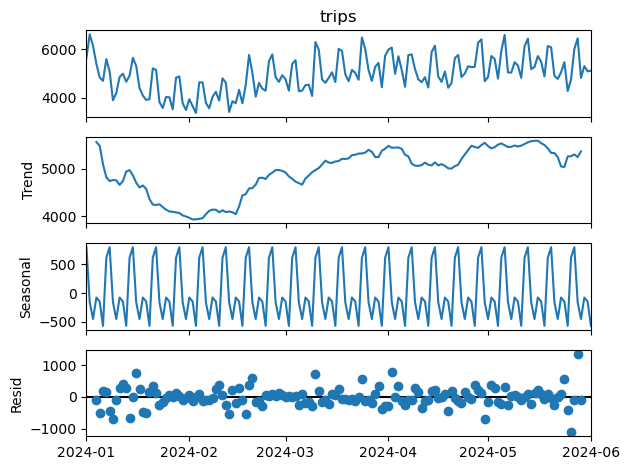

Period: 14


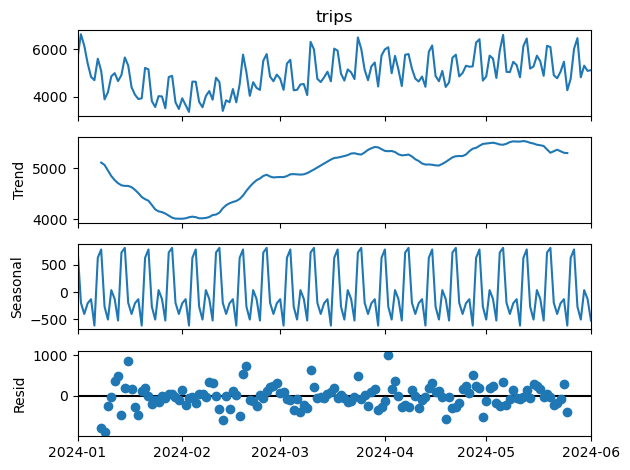

Period: 28


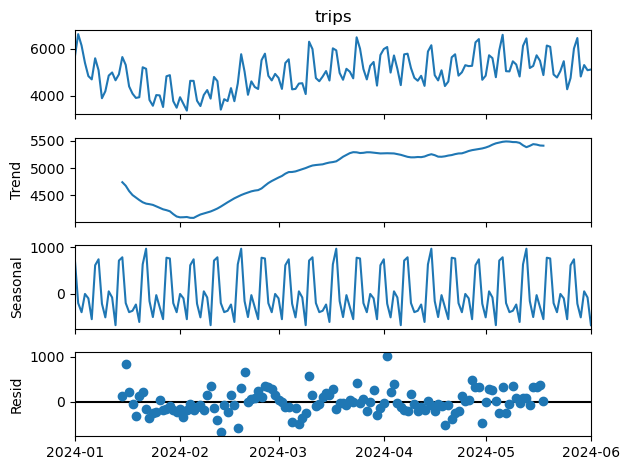

In [53]:
daily_counts_1 = daily_counts["2024-01-01":"2024-06-01"]

# Periods to try:
for period in [7, 14, 28]:
    print(f"Period: {period}")
    result = seasonal_decompose(daily_counts_1, model = "additive", period = period)
    result.plot() 
    plt.show()

Our suspicions have been confirmed and it seems that on a smaller scale we can clearly see weekly and fortnightly seasonality in the daily taxi count. A period of 28 days doesn't seem to be such a great fit however. We will now check whether the hourly time series also has yearly seasonality as well.

Period: 4320


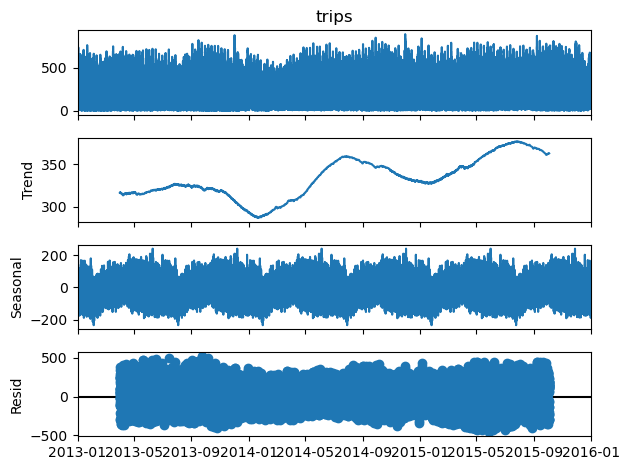

Period: 8760


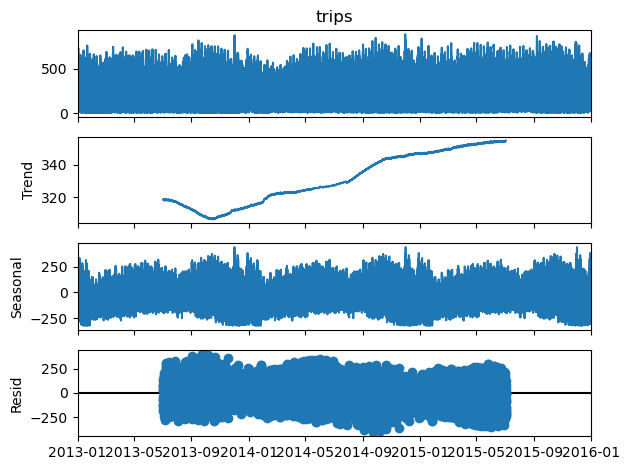

In [60]:
hourly_counts_1 = hourly_counts["2013-01-01":"2016-01-01"]

# Periods to try: (8760 is one year, 4320 is 180 days)
for period in [4320, 8760]:
    print(f"Period: {period}")
    result = seasonal_decompose(hourly_counts_1, model = "additive", period = period)
    result.plot() 
    plt.show()

The above seems to suggest that there actually isn't a yearly seasonality to the hourly count. This actually isn't perhaps that surprising as for yearly seasonality you would need to map each hour of the day one year into the future and expect to see patterns. This is unlikely to occur due to random variation, however if you were to take the count of all taxis within the day (like in daily counts) then it would make sense that this would show some trend year on year. 

## Summary of seasonality findings

To summarise it appears that the daily time series has the following seasonality:

Weekly, fortnightly, yearly.

The hourly time series has the following seasonality:

Daily, every other day, every third day and potentially weekly although not as strong.


## Lags

We now move on to determining which lags to use for our models.

We will use autocorrelation (similarity between current data and lagged data) to determine which lags to use.

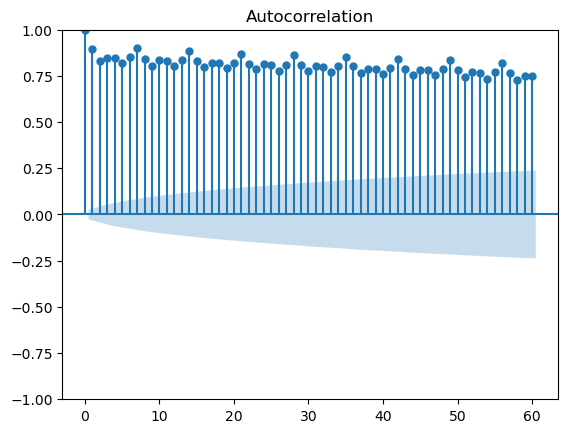

In [72]:
# Let's take a look at an intial 60 lags

plot_acf(daily_counts, lags = 60, alpha = 0.05)
plt.show()

It seems all these lags are significant but it's worth computing manually as well. Before we compute manually we will have a look at the hourly time series.

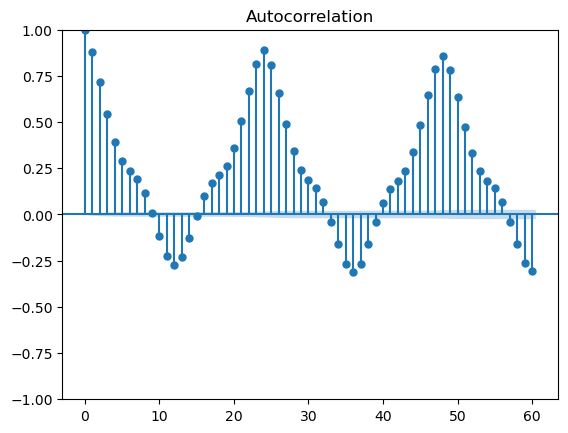

In [74]:
plot_acf(hourly_counts, lags = 60, alpha = 0.05)
plt.show()

Again these all appear significant but it's worth exploring in further detail.

In [122]:
# Compute autocorrelations, we do the first 1000 lags
acf_vals, confint = acf(daily_counts, nlags = 1000, alpha = 0.05)

In [123]:
# To find significant lags we look for lags where 0 lies outside the 95% confidence interval
significant_lags = []
sig_lags_full_info = []
for lag, (val, (low, high)) in enumerate(zip(acf_vals, confint)):
    if lag == 0:
        continue
    if 0 < low or 0 > high:
        significant_lags.append(lag)
        sig_lags_full_info.append((lag, float(val), float(low), float(high)))

print("Significant lags:", significant_lags)
print("\nNumber significant lags:", len(significant_lags))
#print("\nSignificant lags full info:", sig_lags_full_info)

Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,

We see we select 333 lags out of the first 1000, nearly all except 371 being before a full year of 365 days.

We repeat this for the hourly time series.

In [124]:
# Compute autocorrelations, we do the first 100000 lags
acf_vals, confint = acf(hourly_counts, nlags = 100000, alpha = 0.05)

In [125]:
# To find significant lags we look for lags where 0 lies outside the 95% confidence interval
significant_lags_hourly = []
sig_lags_full_info_hourly = []
for lag, (val, (low, high)) in enumerate(zip(acf_vals, confint)):
    if lag == 0:
        continue
    if 0 < low or 0 > high:
        significant_lags_hourly.append(lag)
        sig_lags_full_info_hourly.append((lag, float(val), float(low), float(high)))

print("Significant lags:", significant_lags_hourly)
print("\nNumber significant lags:", len(significant_lags_hourly))
#print("\nSignificant lags full info:", sig_lags_full_info_hourly)

Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 

We get 4,685 significant lags, going all the way up to 11,254. We have computed the first 100,000 so we are pretty confident that there are no more significant lags after this.

We save both lists of significant lags using pickle. Then it is time to move onto building the models.

In [127]:
# Save both lists using pickle
with open("sig_lags_daily.pkl", "wb") as f:
    pickle.dump(significant_lags, f)

with open("sig_lags_hourly.pkl", "wb") as f:
    pickle.dump(significant_lags_hourly, f)